In [162]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
engine = create_engine("postgresql:///kc_housing")
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [163]:
def pullsqldata():
    """This function pulls the necessary columns and rows from the PostGRES DB into a Pandas Dataframe in order 
    to continue with our EDA """
    
    engine = create_engine("postgresql:///kc_housing")
    query = """
                SELECT *
                FROM rpsale AS s
                INNER JOIN resbldg AS b ON CONCAT(s.Major,s.Minor) = CONCAT(b.Major, b.Minor)
                INNER JOIN parcel AS p ON CONCAT(s.Major,s.Minor) = CONCAT(p.Major,p.Minor)
                WHERE EXTRACT(YEAR FROM CAST(documentdate AS DATE)) = 2018
                    AND p.proptype = 'R'
                ;"""
    kc_df = pd.read_sql(sql = query, con = engine)
    return kc_df

In [164]:
def clean_data_initial(df):
    """ This function cleans the housing data by removing outliers and sale price < 10000
    """
    df_clean = df[(df['saleprice']>10000) & (df['saleprice'] <  (2*df['saleprice'].std())+df['saleprice'].mean())]
    return df_clean

In [165]:
df = pullsqldata()
df = clean_data_initial(df)

In [166]:
df_clean = df.drop(['documentdate', 
                               'excisetaxnbr', 
                               'recordingnbr', 
                               'volume',
                               'page',
                               'platnbr',
                               'plattype',
                               'platlot',
                               'platblock',
'sellername',
'buyername',
'streetname',
'streettype',
'directionsuffix',
'zipcode',
'buildingnumber',
'major',
'minor',
'bldggradevar',
'sqfthalffloor',
'sqft2ndfloor',
'sqftupperfloor',
'sqftunfinfull',
'sqftunfinhalf',
'sqfttotbasement',
'sqftfinbasement',
'brickstone',
'viewutilization',
'propname',
'platname',
'platlot',
'platblock',
'range',
'township',
'section',
                               
'quartersection',
'area',
'subarea',
'specarea',
'specsubarea',
'levycode',
'districtname',
'currentzoning',
'topography',
'currentusedesignation',
'salewarning', 
'wetland', 
'stream',
'seismichazard',
'landslidehazard',
'address', 
'airportnoise',
'contamination',
'dnrlease',
 'coalminehazard',
 'criticaldrainage',
 'erosionhazard',
 'landfillbuffer',
 'hundredyrfloodplain',
 'steepslopehazard',
 'speciesofconcern',
 'sensitiveareatract',
 'daylightbasement',
 'fraction',
'directionprefix', 'proptype','unbuildable'], axis=1)

In [167]:
df_clean['othernuisances'] = [x.strip() for x in df_clean['othernuisances']]
df_clean.replace(('Y', 'N'), (1, 0), inplace=True)


/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [168]:
df_clean['ratio'] = df_clean['sqft1stfloor']+df_clean['sqftgarageattached']/df_clean['sqftlot']
df_clean

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,saleprice,propertytype,principaluse,saleinstrument,afforestland,afcurrentuseland,afnonprofituse,afhistoricproperty,salereason,propertyclass,...,historicsite,nativegrowthprotesmt,easements,otherdesignation,deedrestrictions,developmentrightspurch,waterproblems,transpconcurrency,otherproblems,ratio
0,310000.0,3.0,6.0,3.0,0,0,0,0,1.0,8.0,...,0.0,0,0,0,0,0,0,0,0,1200.041379
3,500000.0,3.0,6.0,3.0,0,0,0,0,18.0,8.0,...,0.0,0,0,0,0,0,0,0,0,2100.000000
6,456800.0,11.0,6.0,3.0,0,0,0,0,1.0,8.0,...,0.0,0,0,0,0,0,0,0,0,1580.000000
7,461000.0,11.0,6.0,3.0,0,0,0,0,1.0,8.0,...,0.0,0,0,0,0,0,0,0,0,1740.000000
8,80000.0,1.0,6.0,3.0,0,0,0,0,1.0,7.0,...,0.0,0,0,0,0,0,0,0,0,1200.053226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43732,579000.0,3.0,6.0,3.0,0,0,0,0,1.0,8.0,...,0.0,0,0,0,0,0,0,0,0,1400.000000
43735,483000.0,12.0,6.0,3.0,0,0,0,0,1.0,8.0,...,0.0,0,0,0,0,0,0,0,0,980.000000
43736,483000.0,12.0,6.0,3.0,0,0,0,0,1.0,8.0,...,0.0,0,0,0,0,0,0,0,0,740.000000
43737,205000.0,1.0,6.0,3.0,0,0,0,0,1.0,7.0,...,0.0,0,0,0,0,0,0,0,0,1450.079262


In [169]:
mlr = LinearRegression()

In [170]:
# select = RFE(mlr, n_features_to_select=50)
# select = select.fit(X, y= Y.values.ravel())
# selected_columns = X.columns[select.support_]

In [171]:
X_int = sm.add_constant(X)
model = sm.OLS(Y, X_int).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                 1.495e+04
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:06:14   Log-Likelihood:            -4.0312e+05
No. Observations:               28747   AIC:                         8.062e+05
Df Residuals:                   28745   BIC:                         8.063e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.745e+05   1.23e+04    -62.893      0.000   -7.99e+05    -7.5e+05
x1          1.956e+05   1599.779    122.274      0.000    1.92e+05    1.99e+05
==============================================================================
Omnibus:                     3617.493   Durbin-Watson:                   0.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7181.947
Skew:                           0.798   Prob(JB):                         0.00
Kurtosis:                       4.857   Cond. No.                         54.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [172]:
#this will return a list of columns which correlate to something other than themselves, saleprice can be ignored

corr = df_clean.corr() > .50
corr_list = []
for col in corr.columns:
    if corr[col].sum() > 1:
        print(col)
        corr_list.append(col)

saleprice
bldggrade
sqft1stfloor
sqfttotliving
bedrooms
bathfullcount
fpmultistory
fpadditional
yrbuilt
olympics
territorial
pugetsound
smalllakerivercreek
wfntlocation
wfntfootage
wfntbank
wfntrestrictedaccess
tidelandshoreland
ratio


In [173]:

print("how dropping each element would affect the r_squared values" )
for element in corr_list:
    Y1 = df_clean['saleprice']
    X1 = df_clean.drop(['saleprice', element], axis=1)
    reg = LinearRegression().fit(X1, Y1)
    print(f"dropped {element}:", reg.score(X1, Y1))



how dropping each element would affect the r_squared values
dropped saleprice: 0.5148399783185865
dropped bldggrade: 0.4410018858605864
dropped sqft1stfloor: 0.514141304946262
dropped sqfttotliving: 0.49924642283452114
dropped bedrooms: 0.5123759418542014
dropped bathfullcount: 0.5141077310004046
dropped fpmultistory: 0.5147808208958069
dropped fpadditional: 0.5148074072432614
dropped yrbuilt: 0.4942317484729798
dropped olympics: 0.5146359422140108
dropped territorial: 0.5146139957962272
dropped pugetsound: 0.5147955588771584
dropped smalllakerivercreek: 0.5147689207818474
dropped wfntlocation: 0.5148217189972402
dropped wfntfootage: 0.5148252699775858
dropped wfntbank: 0.5147580357389894
dropped wfntrestrictedaccess: 0.5148391330977189
dropped tidelandshoreland: 0.5148388766783104
dropped ratio: 0.514141153463175


In [174]:
# determine highest correlation factor
from scipy.stats import pearsonr



In [175]:
def find_highest_correlation(df, dep ='saleprice'):
    try:
        X = df.drop([dep], axis = 1)
    except:
        X = df
    Y = df[dep]
    
    num = 0
    for element in X.columns:
        a = pearsonr(list(X[element]),list(Y))
        if np.abs(a[0]) > num:
            num = a[0]
    for element in X.columns:
        a = pearsonr(list(X[element]),list(Y))
        if np.abs(a[0]) == num:
            return element
        


        

In [176]:
find_highest_correlation(df_clean)

'bldggrade'

In [177]:
def check_log_corr(df, dependent = 'saleprice'):
    """this function will take in a dataframe and return a list of independent variables where the log of the function
    returns a higher r_squared value than the function itself"""
    dep = df[dependent]
    Xreg = df.drop(dependent, axis = 1)
    log_list = []
    for col in Xreg.columns:
        if all(value > 1 for value in df[col]):
            print(col)
#             X = np.array(df[element]).reshape(-1,1)      
#             reg1 = LinearRegression().fit(X, dep)
            
#             Xlog = np.log(X)
#             reg2 = LinearRegression().fit(Xlog, dep)
#             print(reg1, reg2)
            
        
df_clean['saleprice']
check_log_corr(df_clean)


principaluse
bldggrade
sqfttotliving
yrbuilt
presentuse
sqftlot


### testing to see if any of the values inprove by looking at the natural log

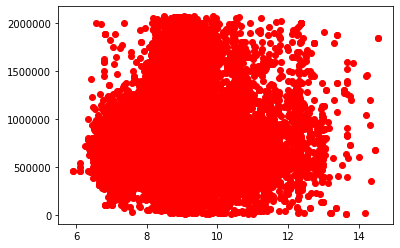

for column: sqftlot, the r_square for the function and log are: 0.0028362092962507246 -0.00024692680447380155 


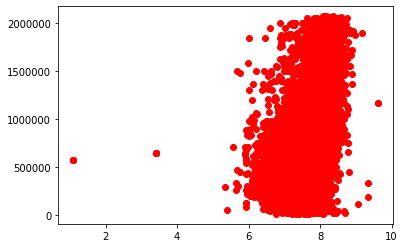

for column: sqfttotliving, the r_square for the function and log are: 0.2943929991946812 -1.5986898678433499 


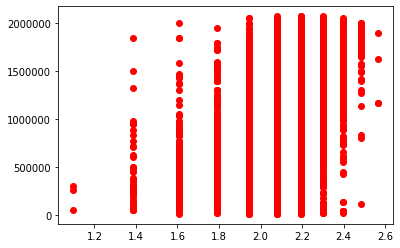

for column: bldggrade, the r_square for the function and log are: 0.34215893473348286 -8.819575038602386 
for column: sqftlot, the r_square for the function and log are: 0.0028362092962507246 -0.00024692680447380155 
for column: sqfttotliving, the r_square for the function and log are: 0.2943929991946812 -1.5986898678433499 
for column: bldggrade, the r_square for the function and log are: 0.34215893473348286 -8.819575038602386 


In [178]:
df_logtester = df_clean[['sqftlot', 'sqfttotliving', 'bldggrade']]
Y = df_clean['saleprice']
for col in df_logtester.columns:
    X = np.array(df_logtester[col]).reshape(-1,1)
    reg = LinearRegression().fit(X, Y)
    r = reg.score(X, Y)
    
    Xlog = np.log(X)
    reglog = LinearRegression().fit(Xlog, Y)
    rlog = reg.score(Xlog, Y)
    
    plt.plot(np.log(X), Y, 'ro')
    plt.show()
    
    print(f"for column: {col}, the r_square for the function and log are: {r} {rlog} ")
    


for col in df_logtester.columns:
    X = np.array(df_logtester[col]).reshape(-1,1)
    reg = LinearRegression().fit(X, Y)
    r = reg.score(X, Y)
    
    Xlog = np.log(X)
    reglog = LinearRegression().fit(Xlog, Y)
    rlog = reg.score(Xlog, Y)
    
    print(f"for column: {col}, the r_square for the function and log are: {r} {rlog} ")

In [179]:
x1 = find_highest_correlation(df_clean)

r_squared_list = []
for element in df_clean:
    X1 = np.array(df_clean[element]).reshape(-1,1)      
    reg = LinearRegression().fit(X1, Y1)
    r_squared_list.append((reg.score(X1, Y1), element))


In [180]:
r_sorted

[(1.0, 'saleprice'),
 (0.342158934733483, 'bldggrade'),
 (0.2943929991946812, 'sqfttotliving'),
 (0.09513145060772099, 'stories'),
 (0.08804165718586376, 'bathfullcount'),
 (0.07465208896328733, 'bedrooms'),
 (0.07325784430673132, 'sqft1stfloor'),
 (0.06048072202771837, 'sqftopenporch'),
 (0.046115911064835036, 'territorial'),
 (0.04356462197492705, 'finbasementgrade'),
 (0.03838073310780421, 'bath3qtrcount'),
 (0.03046862813178075, 'heatsystem'),
 (0.027362973055430336, 'bathhalfcount'),
 (0.026011840734576408, 'fpmultistory'),
 (0.021603966125533502, 'olympics'),
 (0.021467886821468607, 'lakewashington'),
 (0.01966010592978429, 'sqftgarageattached'),
 (0.019394854556952112, 'saleinstrument'),
 (0.018273238424683647, 'addnlcost'),
 (0.017576911209486124, 'yrbuilt'),
 (0.014650397458494169, 'fpsinglestory'),
 (0.013476416368119581, 'pugetsound'),
 (0.011268307432011238, 'salereason'),
 (0.01118679181430493, 'lakesammamish'),
 (0.010079084772140257, 'seattleskyline'),
 (0.00718096885024

In [140]:
r_squared_list.sort()
r_sorted = r_squared_list[::-1]
highest_correlate = [x[1] for x in r_sorted[1:21]]

In [143]:
df_clean['territorial'].value_counts()

0.0    26366
2.0     1532
3.0      593
4.0      256
Name: territorial, dtype: int64

In [223]:
df['bldggrade'] = df['bldggrade'].astype(int) 
df_sale = df['saleprice']

df_high_correlation = df[highest_correlate]
df['bldggrade'] = pd.Categorical(df['bldggrade'])
dfDummies = pd.get_dummies(df['bldggrade'], prefix = 'bldg')



In [242]:
#binning is based on grouping mean values
# seems to decrease R^square value by binning, highest r_squared when no bins
df_bin = dfDummies.join(df_sale, how = 'left')
df_bin[df_bin['bldg_4'] == True]


for n, col in enumerate(df_bin.columns, 3):
    amount = df_bin[df_bin[col] == True]['saleprice'].mean()
    print(col, amount)
    
df_bin['bin3'] = df_bin['bldg_3']
df_bin['bin4-6'] = df_bin['bldg_4']+df_bin['bldg_5']+df_bin['bldg_6']
df_bin['bin7-8'] = df_bin['bldg_7']+df_bin['bldg_8']
df_bin['bin9-10'] = df_bin['bldg_9']+df_bin['bldg_10']
df_bin['bin11-13'] = df_bin['bldg_11']+df_bin['bldg_12']+df_bin['bldg_13']

for col in df_bin.columns:
    if 'bldg' in col:
        del df_bin[col]

Y = df_bin['saleprice']

del df_bin['saleprice']
del df_bin['bin3']

X = df_bin


X_int = sm.add_constant(X)
model = sm.OLS(Y, X_int).fit()
model.summary()


bldg_3 205333.33333333334
bldg_4 461706.52173913043
bldg_5 406094.0588235294
bldg_6 443442.3800763624
bldg_7 574924.3297174111
bldg_8 755997.249553372
bldg_9 1038560.0312345068
bldg_10 1235988.0418521815
bldg_11 1431742.704980843
bldg_12 1654375.4545454546
bldg_13 1464700.0
saleprice nan


/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(ax

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     3190.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        13:45:36   Log-Likelihood:            -4.0386e+05
No. Observations:               28747   AIC:                         8.077e+05
Df Residuals:                   28742   BIC:                         8.078e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.053e+05   1.76e+05      1.164      0.244    -1.4e+05    5.51e+05
bin4-6      2.336e+05   1.76e+05      1.324      0.186   -1.12e+05     5.8e+05
bin7-8       4.51e+05   1.76e+05      2.556      0.011    1.05e+05    7.97e+05
bin9-10     8.762e+05   1.76e+05      4.966      0.000     5.3e+05    1.22e+06
bin11-13    1.259e+06   1.77e+05      7.100      0.000    9.11e+05    1.61e+06
==============================================================================
Omnibus:                     3482.564   Durbin-Watson:                   0.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6595.674
Skew:                           0.789   Prob(JB):                         0.00
Kurtosis:                       4.736   Cond. No.                         275.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
X_int = sm.add_constant(dfDummies)
model = sm.OLS(Y, X_int).fit()
model.summary()

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(ax

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     1607.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:13:30   Log-Likelihood:            -4.0275e+05
No. Observations:               28747   AIC:                         8.055e+05
Df Residuals:                   28736   BIC:                         8.056e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.053e+05    1.7e+05      1.210      0.226   -1.27e+05    5.38e+05
bldg_4      2.564e+05   1.75e+05      1.463      0.143   -8.71e+04       6e+05
bldg_5      2.008e+05    1.7e+05      1.178      0.239   -1.33e+05    5.35e+05
bldg_6      2.381e+05    1.7e+05      1.402      0.161   -9.48e+04    5.71e+05
bldg_7      3.696e+05    1.7e+05      2.177      0.030    3.68e+04    7.02e+05
bldg_8      5.507e+05    1.7e+05      3.243      0.001    2.18e+05    8.83e+05
bldg_9      8.332e+05    1.7e+05      4.906      0.000       5e+05    1.17e+06
bldg_10     1.031e+06    1.7e+05      6.063      0.000    6.97e+05    1.36e+06
bldg_11     1.226e+06   1.71e+05      7.183      0.000    8.92e+05    1.56e+06
bldg_12     1.449e+06   1.75e+05      8.259      0.000    1.11e+06    1.79e+06
bldg_13     1.259e+06   2.25e+05      5.608      0.000    8.19e+05     1.7e+06
==============================================================================
Omnibus:                     3505.985   Durbin-Watson:                   0.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7450.249
Skew:                           0.755   Prob(JB):                         0.00
Kurtosis:                       4.985   Cond. No.                         370.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [191]:
def separate_categorical(df):
    try:
        del df['saleprice']
    except:
        print('saleprice not counted')
    onehotencode_list = []
    for col in df.columns:
        print(col, len(df[col].unique()))
        onehotencode_list.append(col)
    return onehotencode_list


def onhotencode_list(df):
    df_sale = df['saleprice']
    try:
        del df['saleprice']
    except:
        print('saleprice not counted')
    
    for col in df.columns:
        df[col] = pd.Categorical(df[col])
        dfDummies = pd.get_dummies(df[col], prefix = col)
        df_sale.join(dfDummmies, how = 'left', on = Index)
        



separate_categorical(df_clean)




saleprice not counted
propertytype 20
principaluse 4
saleinstrument 18
afforestland 2
afcurrentuseland 2
afnonprofituse 2
afhistoricproperty 2
salereason 16
propertyclass 6
bldgnbr 11
nbrlivingunits 3
stories 4
bldggrade 11
sqft1stfloor 964
sqfttotliving 1334
finbasementgrade 12
sqftgaragebasement 201
sqftgarageattached 426
sqftopenporch 383
sqftenclosedporch 100
sqftdeck 345
heatsystem 9
heatsource 8
bedrooms 16
bathhalfcount 7
bath3qtrcount 9
bathfullcount 8
fpsinglestory 7
fpmultistory 4
fpfreestanding 4
fpadditional 4
yrbuilt 120
yrrenovated 76
pcntcomplete 63
obsolescence 33
pcntnetcondition 9
condition 5
addnlcost 107
hbuasifvacant 12
hbuasimproved 5
presentuse 15
sqftlot 11505
watersystem 5
sewersystem 5
access 6
streetsurface 5
restrictiveszshape 2
inadequateparking 3
pcntunusable 13
mtrainier 4
olympics 4
cascades 4
territorial 4
seattleskyline 4
pugetsound 5
lakewashington 5
lakesammamish 5
smalllakerivercreek 4
otherview 4
wfntlocation 8
wfntfootage 100
wfntbank 5
wfntpoorqu

['propertytype',
 'principaluse',
 'saleinstrument',
 'afforestland',
 'afcurrentuseland',
 'afnonprofituse',
 'afhistoricproperty',
 'salereason',
 'propertyclass',
 'bldgnbr',
 'nbrlivingunits',
 'stories',
 'bldggrade',
 'sqft1stfloor',
 'sqfttotliving',
 'finbasementgrade',
 'sqftgaragebasement',
 'sqftgarageattached',
 'sqftopenporch',
 'sqftenclosedporch',
 'sqftdeck',
 'heatsystem',
 'heatsource',
 'bedrooms',
 'bathhalfcount',
 'bath3qtrcount',
 'bathfullcount',
 'fpsinglestory',
 'fpmultistory',
 'fpfreestanding',
 'fpadditional',
 'yrbuilt',
 'yrrenovated',
 'pcntcomplete',
 'obsolescence',
 'pcntnetcondition',
 'condition',
 'addnlcost',
 'hbuasifvacant',
 'hbuasimproved',
 'presentuse',
 'sqftlot',
 'watersystem',
 'sewersystem',
 'access',
 'streetsurface',
 'restrictiveszshape',
 'inadequateparking',
 'pcntunusable',
 'mtrainier',
 'olympics',
 'cascades',
 'territorial',
 'seattleskyline',
 'pugetsound',
 'lakewashington',
 'lakesammamish',
 'smalllakerivercreek',
 'othe